# Indeed Job Analysis

## Imports

In [2]:
# Pandas is an open source data analysis and manipulation tool
import pandas as pd 

# os gives access to the operating system
import os

# regex library
import re

# Natural language toolkit
from nltk.tokenize import word_tokenize,MWETokenizer
from nltk.corpus import stopwords

# library to create visualizations
import seaborn
# library to create visualizations
import matplotlib.pyplot as plt

# library for lists
import numpy as np

#library to create wordclouds
from wordcloud import WordCloud

# only run below once
#import nltk
#nltk.download("punkt")
#nltk.download("stopwords")

## Load data

In [16]:
# folder path to data
folder_path = "/Users/jan/Documents/7.Semester/Datenanalyse in der Praxis/SeminarArbeit/Data"
# change directory to folder path
os.chdir(folder_path)
# initialize list for all csvs
All_CSVs=[]
#iterate over every file in folder
for file in os.listdir():
    if file.endswith("All_Jobs.csv"):
        break
    if file.endswith(".csv"):   
        # csv to dataframe
        df =pd.read_csv(file, index_col=[0], header=0)
        # append data frame to all csvs list
        All_CSVs.append(df)
# concat all jobs to one data frame
all_jobs = pd.concat(All_CSVs, axis=0, ignore_index=True)

# drop duplicates
all_jobs = all_jobs.drop_duplicates(subset=["1","2","5"],keep="last")

# reindex
all_jobs = all_jobs.reset_index(drop=True)

# rename
all_jobs = all_jobs.rename(columns={'0': 'job_id',"1" : "job_title","2" : "company_name","3" : "company_location",
                                    "4" : "type_of_job","5" : "job_description","6" : "date_info"})

In [17]:
all_jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347 entries, 0 to 346
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   job_title         347 non-null    object
 1   company_name      345 non-null    object
 2   company_location  98 non-null     object
 3   type_of_job       93 non-null     object
 4   job_description   347 non-null    object
 5   date_info         347 non-null    object
dtypes: object(6)
memory usage: 16.4+ KB


## Clean Data

### Clean Job Title

In [18]:
all_jobs["job_title"] =  all_jobs["job_title"].astype(str)
all_jobs["job_title"] =  all_jobs["job_title"].str.replace("\n- job post" , "")
all_jobs["job_title"] =  all_jobs["job_title"].str.replace("\([mwdf]\/[mwdf]\/[mwdf]\)" , "", regex=True)

### Clean job_description

In [19]:
all_jobs["job_description"] =all_jobs["job_description"].astype(str)

## Save all_jobs as CSV

In [20]:
all_jobs.to_csv("/Users/jan/Documents/7.Semester/Datenanalyse in der Praxis/SeminarArbeit/Data/All_Jobs.csv")

## Analysis

### Job Titles

In [15]:
all_jobs.job_title.value_counts().head(10)

Data Analyst                                                            8
Business Analyst                                                        5
Data Engineer                                                           3
Data Analyst (gn)                                                       2
Internship Data Analyst - Purchasing BI                                 2
Business Analyst Intern                                                 2
Topic Owner / Product Manager (Conversion) (gn)                         2
Senior Data Engineer                                                    2
Digital Transformation Lead Consultant & SAP Analyst  - Sykatec GmbH    2
Data Engineer (m/f/x)                                                   2
Name: job_title, dtype: int64

### Top hiring companies

In [9]:
all_jobs.company_name.value_counts().head(10) 

Arvato infoscore GmbH    7
Salesforce               6
Handelsblatt GmbH        6
AUTO1 Group SE           6
Delivery Hero            5
TUI                      5
wefox                    5
Solactive AG             5
Taxfix                   4
Raisin                   4
Name: company_name, dtype: int64

### Top hiring locations

In [75]:
printTopHiringLocations(all_jobs)

berlin               37
homeoffice           16
münchen              14
hamburg              11
frankfurt_am_main     9
Name: tokenized_location, dtype: int64


## Features

In [76]:
def printTopHiringLocations(df):
    df["tokenized_location"] = ""
    for index, row in df.iterrows():
        # check for NaN
        value = row["company_location"]
        #print(value)
        if pd.isnull(value):
            continue
        else:
            # lower all words
            location = row.company_location.lower()
            
            location=location.replace("•"," ")

            #tokenize location
            location = word_tokenize(location)
            
            # handle multi words
            tokenizer = MWETokenizer([("home", "office"), ("frankfurt", "am", "main"), ("bad", "homburg")])
            location = tokenizer.tokenize(location)
            
            #row.tokenized_location = [x.replace("ü","ue") for x in location]
            row.tokenized_location =location
    # explode data frame
    df = df.explode("tokenized_location")
    # cleaning
    df["tokenized_location"] = df["tokenized_location"].replace("home_office","homeoffice")
    # get top locations 
    series = df.tokenized_location.value_counts().head(6)
    # print and drop first empty row
    print(series.drop(series.index[0]))

In [12]:
def tokenizeDescription(df):
    tokenized_df = df
    # create new column for tokens
    tokenized_df["tokenized_description"] = ""
    # iterate over rows
    for index, row in tokenized_df.iterrows():
        # lower all words
        description = row.job_description.lower()

        # tokenize description
        description = word_tokenize(description)

        # remove duplicates
        description = list(set(description))

        # remove stopwords etc (english)
        description = [word for word in description if word not in stopwords.words("english")]

        # remove stopwords etc (german)
        description = [word for word in description if word not in stopwords.words("german")]

        # add to new "tokenized_description" column
        row.tokenized_description=description
    return tokenized_df
        

In [13]:
def plotSkillSet(df, keywords,title): 
    # get all keywords
    count_keywords=pd.DataFrame(df.tokenized_description.sum()).value_counts().\
        rename_axis("keywords").reset_index(name="counts")
    # get ammount of jobs
    length =len(all_jobs)

    # calculate proportion
    count_keywords["percentage"] = 100 * count_keywords.counts / length

    # plotting
    count_keywords = count_keywords[count_keywords.keywords.isin(keywords)]
    count_keywords = count_keywords.head(10)

    graph = seaborn.barplot(x="keywords", y="percentage", data = count_keywords)
    graph.set_xticklabels(graph.get_xticklabels(), 
                            rotation=45, 
                            horizontalalignment='right')
    plt.xlabel("")
    plt.ylabel("Probability to be in job posting (%)")
    plt.title(title) 
    plt.show(graph)
    print(count_keywords)



In [54]:
def buildWordCloud(df,keywords):
    # initialize empty string
    text = ""
    # initialize empty list
    flat_list = []
    # get all tokenized descriptions as list
    tokenized_description_list = tokenized_df.tokenized_description.tolist()
    # flatten list 
    for sublist in tokenized_description_list:
        for item in sublist:
            flat_list.append(item)           
    # filter for keywords
    keywords_only = [item for item in flat_list if item in keywords]
    # build string for wordcloud
    text = " ".join(word for word in keywords_only)
    # build wordcloud
    wc = WordCloud(background_color="white", collocations=False).generate(text)
    # show wordcloud
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    

## Tokenize Description

In [15]:
tokenized_df = tokenizeDescription(all_jobs)

## Keywords

In [63]:
# analyst skills
keywords = ["excel" , "python" , "r" ,"matlab", "ai", "ki", "mysql" , "linux", "c",
            "visio", "java", "javascript", "vba", "powerpoint", "github", "git", "gitlab",
            "sql", "mysql", "sqlight"]

## Data Analyst Skills

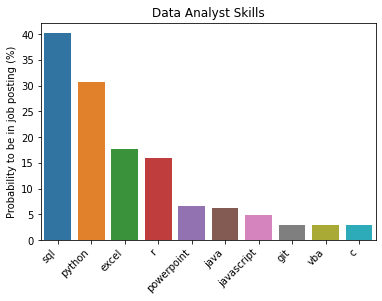

        keywords  counts  percentage
32           sql     123   40.196078
61        python      94   30.718954
213        excel      54   17.647059
255            r      49   16.013072
817   powerpoint      20    6.535948
833         java      19    6.209150
1117  javascript      15    4.901961
1715         git       9    2.941176
1844         vba       9    2.941176
1856           c       9    2.941176


In [64]:
plotSkillSet(tokenized_df, keywords, "Data Analyst Skills")

## Wordcloud

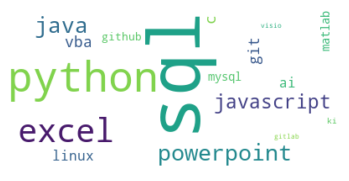

In [65]:
buildWordCloud(tokenized_df, keywords)

### Python vs R

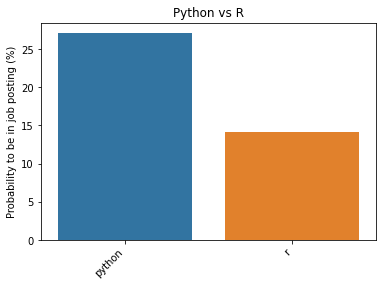

    keywords  counts  percentage
61    python      94   27.089337
255        r      49   14.121037


In [78]:
python_R_keywords = ["python" , "r"]
plotSkillSet(tokenized_df,python_R_keywords, "Python vs R")